<a href="https://colab.research.google.com/github/jaguzman/GENERAL-FundamentosEnHerramientasDeTransformacionDigital/blob/master/Unidad%203%20-%20Aprendizaje%20de%20m%C3%A1quinas/3_Aprendizaje%20No%20Supervisado/ReglasAsociacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reglas de Asociación


Se cuenta con una base de datos de los registros de venta de una panadería en Edinburgh, Escocia. Los registros se tomaron desde el 29/oct/2016 hasta el 8/abr/2017.

Información del dataset: https://www.kaggle.com/sulmansarwar/transactions-from-a-bakery


**OBJETIVO**

La idea el argoritmo para encontrar asociaciones en los productos y poder dar respuesta a preguntas como: ¿cuáles son los productos más vendidos?, ¿cuáles son los productos más frecuentes?, ¿cuáles son los productos más relacionados?, etc.

**Contenido**

*   Importar librerías
*   Importar la base de datos
*   Descripción y analítica de los datos
*   Algoritmo de Reglas de Asociación
*   Actividad

# **LIBRERÍAS**

In [1]:
# Importar la librería

import numpy as np 
import pandas as pd 

# Librerías para graficar
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías de Aprendizaje de máquinas
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**IMPORTAR LA BASE DE DATOS**

In [2]:
# Leer los datos desde el GitHub
data = pd.read_csv("https://raw.githubusercontent.com/jaguzman/dataSets/master/datasets/BreadBasket_DMS.csv",
    sep = ',',         # separador de campos
    thousands = None,  # separador de miles para números
    decimal = '.')     # separador de los decimales para números

# Imprimir el tamaño de la base de datos
print(data.shape)
# Imprimir las primeras 7 líneas
data.head(7)

(21293, 4)


,Date,Time,Transaction,Item
0,2016-10-30,09:58:11,1,Bread
1,2016-10-30,10:05:34,2,Scandinavian
2,2016-10-30,10:05:34,2,Scandinavian
3,2016-10-30,10:07:57,3,Hot chocolate
4,2016-10-30,10:07:57,3,Jam
5,2016-10-30,10:07:57,3,Cookies
6,2016-10-30,10:08:41,4,Muffin


**DESCRIPCIÓN DE LA BASE DE DATOS**

**Datos bancarios del cliente**

**[1] Date:** fecha de la compra (estampa de tiempo)

**[2] Time:** hora de la compra (estampa de tiempo)

**[3] Transaction:** número de indentificación de la compra. En cada fila se registra un artículo, pero este puede pertenecer a un grupo de artículos comprados. (numérico) 

**[4] Item:** artículo comprado (categórica)

In [3]:
# Información de la base de datos: nómbre de la columna, conteo de datos Null y tipo de datos
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21293 entries, 0 to 21292
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         21293 non-null  object
 1   Time         21293 non-null  object
 2   Transaction  21293 non-null  int64 
 3   Item         21293 non-null  object
dtypes: int64(1), object(3)
memory usage: 665.5+ KB


# **DESCRIPCIÓN Y ANALÍTICA DE DATOS**

Descripción de la columna 'Transaction'.

In [4]:
# descripción de variables numéricas de la base de datos
data.describe()

,Transaction
count,21293.000000
mean,4951.990889
std,2787.758400
min,1.000000
25%,2548.000000
50%,5067.000000
75%,7329.000000
max,9684.000000


Se puede ver que la base de datos cuenta con 9684 compras.

En la columna de 'item' existen datos etiquetados como NONE, estos se deben eliminar.

In [5]:
# Contar el número de regisros que tiene el contenido 'NONE' en la columna 'Item'
data.loc[data['Item']=='NONE',:].count()

Date           786
Time           786
Transaction    786
Item           786
dtype: int64

In [0]:
# Eliminar los registros 'NONE'
data=data.drop(data.loc[data['Item']=='NONE'].index)

Para saber cuantos antículos diferentes vende la panadería se usa la siguiente función en la columna 'Item'

In [7]:
# Cuenta los artículos distintos en la columna
data['Item'].nunique()

94

Ahora se listan los 10 más vendidos.

In [8]:
# Se cuenta el número de veces que aparece cada artículo, se ordenan descendentemente y se imprimen los primeros 10
data['Item'].value_counts().sort_values(ascending=False).head(10)

Coffee           5471
Bread            3325
Tea              1435
Cake             1025
Pastry            856
Sandwich          771
Medialuna         616
Hot chocolate     590
Cookies           540
Brownie           379
Name: Item, dtype: int64

El café es el artículo más vendido. Incluso supera 10 en ventas las galletas que están en el puesto 9.

Ahora se grafica esta relación

Text(0.5, 1.0, 'Los más vendidos')

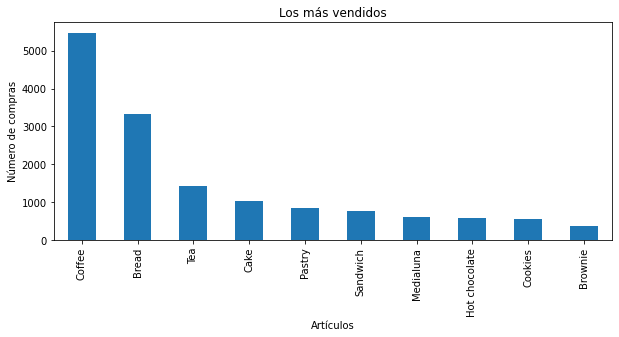

In [9]:
# Tamaño de la gráfica
plt.figure(figsize=(10,4))
# Top 10 de los artículos más vendidos
data['Item'].value_counts().sort_values(ascending=False).head(10).plot(kind='bar')
# Nombre del eje y
plt.ylabel('Número de compras')
# Nombre del eje x
plt.xlabel('Artículos')
# Título
plt.title('Los más vendidos')

Relación del número de ventas con la hora del día. Se analizarán las ventas durante la mañana, la tarde y la noche. Para esto se crea una nueva columna y se agrupa por la hora de la compra.

In [10]:
# Crear nueva columna 'Daytime' y se ingresa el nombre de la parte del día, según corresponda.
data.loc[(data['Time']<'12:00:00'),'Daytime']='Morning'
data.loc[(data['Time']>='12:00:00')&(data['Time']<'18:00:00'),'Daytime']='Afternoon'
data.loc[(data['Time']>='17:00:00')&(data['Time']<'23:50:00'),'Daytime']='Night'
data.head()

,Date,Time,Transaction,Item,Daytime
0,2016-10-30,09:58:11,1,Bread,Morning
1,2016-10-30,10:05:34,2,Scandinavian,Morning
2,2016-10-30,10:05:34,2,Scandinavian,Morning
3,2016-10-30,10:07:57,3,Hot chocolate,Morning
4,2016-10-30,10:07:57,3,Jam,Morning


Text(0.5, 1.0, 'Ventas durante el día')

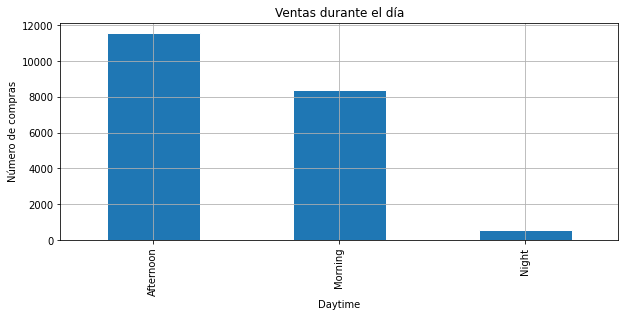

In [11]:
# Tamaño de la gráfica
fig, ax=plt.subplots(figsize=(10,4))
# Estílo de la gráfica
sns.set_style('darkgrid')
# Se cuenta por parte del día y se cuenta
data.groupby('Daytime')['Item'].count().plot(kind='bar')
# Nombre del eje y
plt.ylabel('Número de compras')
# Título
plt.title('Ventas durante el día')

Es evidente que la panadería vende más productos en la tarde, la siguiente parte de más ventas es la mañana y finalmente en la noche se venden menos productos.

In [12]:
# Número de ventas realizadas por parte del día
data.groupby('Daytime')['Item'].count().sort_values(ascending=False)

Daytime
Afternoon    11569
Morning       8404
Night          534
Name: Item, dtype: int64

La panadería vendió 11569 artículo en la mañana y sólo 534 en la noche.

La fecha se puede separar para extraer más información, es decir, el día de la semana, el mes y el año.

In [13]:
# Una estamapa de tiempo está compuesta por la feha y la hora, para esto se agrupan las columnas 'Date' y 'Time'
data['TimeStamp']=pd.to_datetime(data['Date']+' '+data['Time'])
# Se extrae el día de la semana
data['Day']=data['TimeStamp'].dt.day_name()
# Se extrae el mes
data['Month']=data['TimeStamp'].dt.month
# Se extrae el nombre del mes
data['Month_name']=data['TimeStamp'].dt.month_name()
# Se extrae el año
data['Year']=data['TimeStamp'].dt.year
# Se agrupa el año y el nombre del mes
data['Year_Month']=data['Year'].apply(str)+' '+data['Month_name'].apply(str)
# Se eliminan las columnas separadas de fecha y hora
data.drop(['Date','Time'], axis=1, inplace=True)
# Se imprimen las primeras líneas de la base de datos
data.head()

,Transaction,Item,Daytime,TimeStamp,Day,Month,Month_name,Year,Year_Month
0,1,Bread,Morning,2016-10-30 09:58:11,Sunday,10,October,2016,2016 October
1,2,Scandinavian,Morning,2016-10-30 10:05:34,Sunday,10,October,2016,2016 October
2,2,Scandinavian,Morning,2016-10-30 10:05:34,Sunday,10,October,2016,2016 October
3,3,Hot chocolate,Morning,2016-10-30 10:07:57,Sunday,10,October,2016,2016 October
4,3,Jam,Morning,2016-10-30 10:07:57,Sunday,10,October,2016,2016 October


Se desea conocer la relación de ventas con respecto a los meses del año

Text(0.5, 1.0, 'Ventas de los meses')

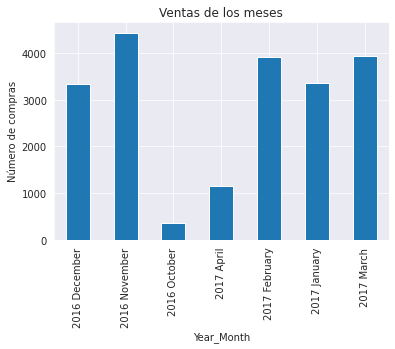

In [14]:
# Realiza un conteo de las ventas por cada mes del año
data.groupby('Year_Month')['Item'].count().plot(kind='bar')
# Nombre del eje y
plt.ylabel('Número de compras')
# Título
plt.title('Ventas de los meses')

Se ve que las ventas de octubre y abril son bajas, pero esto se debe a que en esos meses se tomaron pocos registros pues la base de datos tiene registros delos registros se hicieron desde el 29/oct/2016 hasta el 8/abr/2017.

Con el objetivo de ver la cantidad de artículos que más se vendieron mensualmente, se hace lo siguiente.

In [15]:
# Se crea una tabla donde las filas se ubican los nombre de los meses y en las columnas los artículo y se agrupan por número de artículos
data2=data.pivot_table(index='Month_name',columns='Item', aggfunc={'Item':'count'}).fillna(0)
# Se agrega una columna al final con el artículo más vendido en casa mes
data2['Max']=data2.idxmax(axis=1)
# Se imprime la tabla
data2

Item                           ...                              Max
Item       Adjustment Afternoon with the baker  ... Victorian Sponge                
Month_name                                      ...                                 
April             0.0                      2.0  ...              0.0  (Item, Coffee)
December          0.0                      0.0  ...              0.0  (Item, Coffee)
February          0.0                     13.0  ...              0.0  (Item, Coffee)
January           0.0                     15.0  ...              0.0  (Item, Coffee)
March             0.0                     14.0  ...              0.0  (Item, Coffee)
November          1.0                      0.0  ...              4.0  (Item, Coffee)
October           0.0                      0.0  ...              3.0  (Item, Coffee)

[7 rows x 95 columns]

El cafe el el producto que mas se vende cada mes.

Cantidad de artículos que más se vendieron en los días de la semana

In [16]:
# Se crea una tabla donde las filas se ubican los días de la semana y en las columnas los artículo y se agrupan por número de artículos
data4=data.pivot_table(index='Day',columns='Item', aggfunc={'Item':'count'}).fillna(0)
# Se agrega una columna al final con el artículo más vendido en cada día de la semana
data4['Max']=data4.idxmax(axis=1)
# Se imprime la tabla
data4

Item                           ...                              Max
Item      Adjustment Afternoon with the baker  ... Victorian Sponge                
Day                                            ...                                 
Friday           0.0                      7.0  ...              0.0  (Item, Coffee)
Monday           0.0                      5.0  ...              0.0  (Item, Coffee)
Saturday         0.0                     12.0  ...              1.0  (Item, Coffee)
Sunday           0.0                     14.0  ...              4.0  (Item, Coffee)
Thursday         0.0                      2.0  ...              0.0  (Item, Coffee)
Tuesday          0.0                      2.0  ...              1.0  (Item, Coffee)
Wednesday        1.0                      2.0  ...              1.0  (Item, Coffee)

[7 rows x 95 columns]

In [17]:
data.head()

,Transaction,Item,Daytime,TimeStamp,Day,Month,Month_name,Year,Year_Month
0,1,Bread,Morning,2016-10-30 09:58:11,Sunday,10,October,2016,2016 October
1,2,Scandinavian,Morning,2016-10-30 10:05:34,Sunday,10,October,2016,2016 October
2,2,Scandinavian,Morning,2016-10-30 10:05:34,Sunday,10,October,2016,2016 October
3,3,Hot chocolate,Morning,2016-10-30 10:07:57,Sunday,10,October,2016,2016 October
4,3,Jam,Morning,2016-10-30 10:07:57,Sunday,10,October,2016,2016 October


# **Reglas de asociación**



Se realiza un análisis de reglas de asociación de los productos. Las métricas a medir la asociación son:
1. Soporte: es la medida de frecuencia o abundancia de un elemento en un conjunto de datos. Puede ser 'soporte antecedente', 'soporte consecuente' y 'soporte'. El 'soporte antecedente' contiene la proporción de transacciones realizadas para el antecedente, mientras que el 'soporte consecuente' involucra a las correspondientes. El 'soporte' se calcula tanto para el antecedente como para el consecuente en cuestión.
2. Confianza: esto da la probabilidad de consecuente en una transacción dada la presencia de antecedente.
3. Interés: dado que los antecedentes y los consecuentes son independientes, con qué frecuencia se juntan / compran juntos.
4. Apalancamiento: es la diferencia entre la frecuencia del antecedente y el consecuente juntos en transacciones a la frecuencia de ambos en transacciones independientes.
5. Convicción: un puntaje de convicción más alto significa que el consecuente depende mucho del antecedente.

El algoritmo se utiliza para extraer conjuntos de elementos frecuentes que se utilizan para el análisis de reglas de asociación. En este algoritmo, el usuario define un soporte mínimo que es el umbral mínimo que decide si un conjunto de elementos se considera "frecuente".

Inicialmente se hace un conjunto de datos que contiene listas de artículos que se compraron juntos.

In [18]:
lst=[]
for item in data['Transaction'].unique():
    lst2=list(set(data[data['Transaction']==item]['Item']))
    if len(lst2)>0:
        lst.append(lst2)
print(lst[0:3])
print(len(lst))

[['Bread'], ['Scandinavian'], ['Cookies', 'Jam', 'Hot chocolate']]
9465


Para el algoritmo Apriori, este conjunto de datos debe estar codificado. Esto se realiza utilizando TransactionEncoder como se muestra aquí, seguido de un algoritmo para obtener los conjuntos de elementos frecuentes. Luego se utiliza la función de reglas de asociación que puede tomar cualquier métrica. Aquí he usado 'lift' y he especificado el umbral mínimo como 1.  

In [19]:
# Los algoritmos se codifican
te=TransactionEncoder()
te_data=te.fit(lst).transform(lst)
data_x=pd.DataFrame(te_data,columns=te.columns_)
print(data_x.head())

   Adjustment  Afternoon with the baker  ...  Vegan mincepie  Victorian Sponge
0       False                     False  ...           False             False
1       False                     False  ...           False             False
2       False                     False  ...           False             False
3       False                     False  ...           False             False
4       False                     False  ...           False             False

[5 rows x 94 columns]


In [20]:
# Los artículos más frecuentes
frequent_items= apriori(data_x, use_colnames=True, min_support=0.03)
print(frequent_items.head())

    support     itemsets
0  0.036344  (Alfajores)
1  0.327205      (Bread)
2  0.040042    (Brownie)
3  0.103856       (Cake)
4  0.478394     (Coffee)


In [21]:
# los artículos con su antecedente y consecuente y sus respectivas métricas
rules = association_rules(frequent_items, metric="lift", min_threshold=1)
rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Cake),(Coffee),0.103856,0.478394,0.054728,0.526958,1.101515,0.005044,1.102664
1,(Coffee),(Cake),0.478394,0.103856,0.054728,0.114399,1.101515,0.005044,1.011905
2,(Coffee),(Medialuna),0.478394,0.061807,0.035182,0.073542,1.189878,0.005614,1.012667
3,(Medialuna),(Coffee),0.061807,0.478394,0.035182,0.569231,1.189878,0.005614,1.210871
4,(Pastry),(Coffee),0.086107,0.478394,0.047544,0.552147,1.154168,0.006351,1.164682
5,(Coffee),(Pastry),0.478394,0.086107,0.047544,0.099382,1.154168,0.006351,1.014740
6,(Coffee),(Sandwich),0.478394,0.071844,0.038246,0.079947,1.112792,0.003877,1.008807
7,(Sandwich),(Coffee),0.071844,0.478394,0.038246,0.532353,1.112792,0.003877,1.115384


El café es el más vendido de esta panadería y muestra asociación con 4 artículos: pastelería, pastel, medialuna y sándwich.
Hay un par de estrategias que la panadería puede adoptar para aumentar sus ventas teniendo en cuenta la asociación que hemos visto con el café.


# **ACTIVIDAD**

Se tiene una base de datos de compras en un supermercado. 
1. Graficar los 5 artículos más vendidos.
2. Imprimir los artículos más frecuentes.
3. Realizar el análisis de reglas de asiciación de los productos

**IMPORTAR LA BASE DE DATOS**

In [22]:
# Leer los datos desde el GitHub
dataTable = pd.read_csv("https://raw.githubusercontent.com/jaguzman/dataSets/master/datasets/dataset_group_RandomShoppingCart.csv",
    sep = ',',         # separador de campos
    thousands = None,  # separador de miles para números
    decimal = '.')     # separador de los decimales para números

# Imprimir el tamaño de la base de datos
print(dataTable.shape)
# Imprimir las primeras líneas
dataTable.head()

(22343, 3)


,Date,Transaction,Item
0,2000-01-01,1,yogurt
1,2000-01-01,1,pork
2,2000-01-01,1,sandwich bags
3,2000-01-01,1,lunch meat
4,2000-01-01,1,all- purpose


**DESCRIPCIÓN DE LA BASE DE DATOS**

**[1] Date:** fecha de la compra (estampa de tiempo)

**[2] Transaction:** número de indentificación de la compra. En cada fila se registra un artículo, pero este puede pertenecer a un grupo de artículos comprados. (numérico) 

**[4] Item:** artículo comprado (categórica)

**Solución 1. Los 5 artículos más vendidos**

Text(0.5, 1.0, 'Los más vendidos')

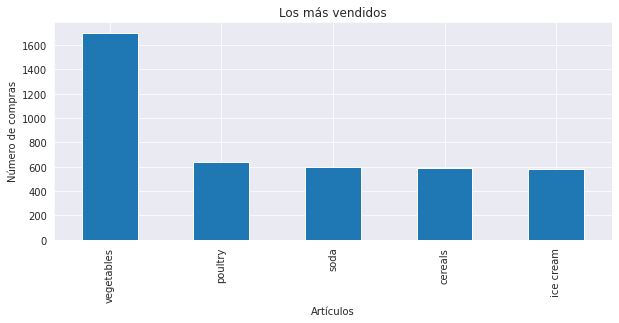

In [23]:
# Tamaño de la gráfica
plt.figure(figsize=(10,4))
# Top 10 de los artículos más vendidos
dataTable['Item'].value_counts().sort_values(ascending=False).head(5).plot(kind='bar')
# Nombre del eje y
plt.ylabel('Número de compras')
# Nombre del eje x
plt.xlabel('Artículos')
# Título
plt.title('Los más vendidos')

**Solución 2. Los artículos más frecuentes**

Conjunto de datos que contiene listas de artículos que se compraron juntos.

In [24]:
lst=[]
for item in dataTable['Transaction'].unique():
    lst2=list(set(dataTable[dataTable['Transaction']==item]['Item']))
    if len(lst2)>0:
        lst.append(lst2)
print(lst[0:3])
print(len(lst))

[['pork', 'butter', 'vegetables', 'sandwich bags', 'lunch meat', 'aluminum foil', 'dinner rolls', 'mixes', 'laundry detergent', 'beef', 'soap', 'ice cream', 'all- purpose', 'flour', 'soda', 'shampoo', 'yogurt'], ['yogurt', 'vegetables', 'sandwich bags', 'aluminum foil', 'toilet paper', 'laundry detergent', 'hand soap', 'cereals', 'milk', 'waffles', 'mixes', 'individual meals', 'tortillas', 'shampoo', 'dishwashing liquid/detergent', 'cheeses'], ['pork', 'poultry', 'sandwich loaves', 'vegetables', 'bagels', 'lunch meat', 'dinner rolls', 'toilet paper', 'laundry detergent', 'spaghetti sauce', 'hand soap', 'eggs', 'cereals', 'soap', 'milk', 'ice cream', 'soda', 'shampoo', 'cheeses', 'ketchup']]
1139


In [25]:
# Los algoritmos se codifican
te=TransactionEncoder()
te_data=te.fit(lst).transform(lst)
data_x=pd.DataFrame(te_data,columns=te.columns_)
print(data_x.head())

   all- purpose  aluminum foil  bagels  ...  vegetables  waffles  yogurt
0          True           True   False  ...        True    False    True
1         False           True   False  ...        True     True    True
2         False          False    True  ...        True    False   False
3          True          False   False  ...       False    False   False
4          True          False   False  ...        True     True    True

[5 rows x 38 columns]


In [26]:
# Los artículos más frecuentes
frequent_items= apriori(data_x, use_colnames=True, min_support=0.03)
print(frequent_items.head())

    support         itemsets
0  0.374890   (all- purpose)
1  0.384548  (aluminum foil)
2  0.385426         (bagels)
3  0.374890           (beef)
4  0.367867         (butter)


**Solución 3. Análisis de Reglas de Asiciación de los productos** 

In [27]:
# los artículos con su antecedente y consecuente y sus respectivas métricas
rules = association_rules(frequent_items, metric="lift", min_threshold=1)
rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(all- purpose),(aluminum foil),0.374890,0.384548,0.157155,0.419204,1.090121,0.012992,1.059670
1,(aluminum foil),(all- purpose),0.384548,0.374890,0.157155,0.408676,1.090121,0.012992,1.057135
2,(bagels),(all- purpose),0.385426,0.374890,0.150132,0.389522,1.039028,0.005639,1.023967
3,(all- purpose),(bagels),0.374890,0.385426,0.150132,0.400468,1.039028,0.005639,1.025091
4,(beef),(all- purpose),0.374890,0.374890,0.144864,0.386417,1.030747,0.004321,1.018786
5,(all- purpose),(beef),0.374890,0.374890,0.144864,0.386417,1.030747,0.004321,1.018786
6,(butter),(all- purpose),0.367867,0.374890,0.147498,0.400955,1.069525,0.009588,1.043510
7,(all- purpose),(butter),0.374890,0.367867,0.147498,0.393443,1.069525,0.009588,1.042166
8,(cereals),(all- purpose),0.395961,0.374890,0.151010,0.381375,1.017297,0.002568,1.010482
9,(all- purpose),(cereals),0.374890,0.395961,0.151010,0.402810,1.017297,0.002568,1.011469
